In [5]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import galois
from mec import make_circle
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import skew

In [35]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [9,6,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[5]
# code = [18,12,1,11,3,2,15,1]
# code = [28,14,26,6,8,7,9,20]
# code = [4,4,3,1,2,3,1,2]
# code = [6,6,1,1,6,2,5,6]
# code = [6,6,1,3,4,1,3,4]
# code = [30,6,5,4,5,1,18,7] # 0.980 at 16.66% masked
# code = [12,12,7,7,6,3,10,5]
# code = [15,3,13,0,1,2,6,2]
# code = [15,3,7,0,1,1,1,0] # 0.980 at 13.33% masked
# code = [15,3,14,0,1,1,0,8]

# code = [30,6,27,1,2,3,29,28] # [[360,12,12]] 0.984
# code = [30,6,27,5,4,3,11,22] # [[360,12,12]] 0.9784
# code = [30,6,27,2,1,3,29,1] # [[360,8,12]] 0.9803
# code = [30,6,21,1,2,0,17,4] # [[360,8,12]] 0.9774
# code = [30,6,27,5,4,3,11,22] # [[360,12,12]] 0.9774
# code = [30,6,21,4,5,3,23,7] # [[360,8,12]] 0.9794
# code = [15,3,11,1,0,0,14,13]
code = [15,3,11,2,0,0,11,13]

In [36]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [37]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [38]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [39]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

k = 4


In [40]:
def has_toric_layout():
    # As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    # Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]
    As = [A1 @ A2.T, A2 @ A1.T, A2 @ A3.T, A3 @ A2.T, A1 @ A3.T, A3 @ A1.T ]
    Bs = [B1 @ B2.T, B2 @ B1.T, B2 @ B3.T, B3 @ B2.T, B1 @ B3.T, B3 @ B1.T]


    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(AA) for AA in As]
        Borders = [order(BB) for BB in Bs]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        for i in range(emb_m):
            tmp_qbt = (ver**i)[0].indices[0] if i else 0
            for j in range(emb_ell):
                visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

confirmed_codes = has_toric_layout()
print(confirmed_codes)

[(3, 15, 2, 0), (3, 15, 2, 1), (3, 15, 2, 2), (3, 15, 2, 3), (3, 15, 2, 4), (3, 15, 2, 5), (3, 15, 3, 0), (3, 15, 3, 1), (3, 15, 3, 2), (3, 15, 3, 3), (3, 15, 3, 4), (3, 15, 3, 5)]


In [41]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

In [42]:
for c,code in enumerate(confirmed_codes):
    lattice = embed_code(code, 0) 
    
    colors = np.empty(lattice.shape, dtype=object)
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "x":
                colors[i][j] = "red"
            elif lattice[i][j][0] == "r":
                colors[i][j] = "orange"
            elif lattice[i][j][0] == "l":
                colors[i][j] = "blue"
            else:
                colors[i][j] = "green"

    qbts = np.array([None for i in range(2*m*ell)])
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
                qbts[int(lattice[i][j][1:])] = (i, j)

    rs = []
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hx[i])[0]]
        rs.append(make_circle(gen_qbts)[2])
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hz[i])[0]]
        rs.append(make_circle(gen_qbts)[2])

    print(c, code, skew(rs))
    # scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

    # bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
    # counts, _ = np.histogram(scaled_rs, bins=bins)
    # counts_weighter = counts.sum()

    # print(code, sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])]))
    # print(code, np.percentile(scaled_rs, 70))
    # plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, label=f"{code}", alpha=0.7)
    # plt.legend()

0 (3, 15, 2, 0) 2.107958359931433
1 (3, 15, 2, 1) 3.340787563580471
2 (3, 15, 2, 2) 1.5079307606196808
3 (3, 15, 2, 3) 1.0636586270696793
4 (3, 15, 2, 4) 1.494359420460468
5 (3, 15, 2, 5) 2.14632796051496
6 (3, 15, 3, 0) 2.0741365878118874
7 (3, 15, 3, 1) 3.2459494512494937
8 (3, 15, 3, 2) 1.485159409915457
9 (3, 15, 3, 3) 1.0475455833688598
10 (3, 15, 3, 4) 1.4731467474674065
11 (3, 15, 3, 5) 2.107780576603766


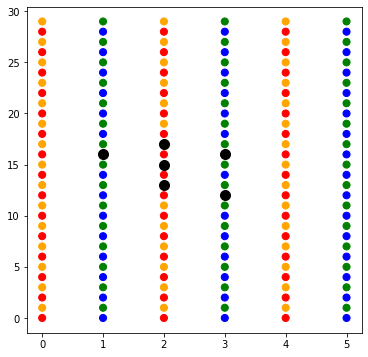

In [46]:
lattice = embed_code(confirmed_codes[5], 0) 
    
colors = np.empty(lattice.shape, dtype=object)

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)



nodes = itertools.product(np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))

gen_qbts = qbts[np.where(Hx[4])[0]]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=50, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=100, c='k')

In [47]:
for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    for qbt in gen_qbts:
        if (abs(qbt[0] - x_check[0]) + abs(qbt[1] - x_check[1])) > 1:
            nonlocal_qbts.append(qbt)

    print([nonlocal_qbts, x_check], end=", ")
    # if (len(nonlocal_qbts) > 2): print(f'more than 2 nonlocal', end=" ")
    if make_circle(gen_qbts)[2] > 10: print('large', end=" ")
    print()

print()
# for i, z_check in enumerate(z_checks):
#     gen_qbts = qbts[np.where(Hz[i])[0]]

#     nonlocal_qbts = []
#     for qbt in gen_qbts:
#         if (abs(qbt[0] - z_check[0]) + abs(qbt[1] - z_check[1])) > 1:
#             nonlocal_qbts.append(qbt)

#     print([nonlocal_qbts, z_check], end=", ")
#     # if (len(nonlocal_qbts) > 2): print(f'more than 2 nonlocal', end=" ")
#     if make_circle(gen_qbts)[2] > 10: print('large', end=" ")
#     print()
    
    

[[(5, 0), (1, 26), (0, 27), (0, 29)], (0, 0)], large 
[[(3, 26), (2, 27), (2, 29)], (2, 0)], large 
[[(5, 26), (4, 27), (4, 29)], (4, 0)], large 
[[(5, 16), (1, 12), (0, 13)], (0, 16)], 
[[(3, 12), (2, 13)], (2, 16)], 
[[(5, 12), (4, 13)], (4, 16)], 
[[(5, 2), (1, 28), (0, 29)], (0, 2)], large 
[[(3, 28), (2, 29)], (2, 2)], large 
[[(5, 28), (4, 29)], (4, 2)], large 
[[(5, 18), (1, 14), (0, 15)], (0, 18)], 
[[(3, 14), (2, 15)], (2, 18)], 
[[(5, 14), (4, 15)], (4, 18)], 
[[(1, 0), (5, 4), (0, 1)], (0, 4)], 
[[(3, 0), (2, 1)], (2, 4)], 
[[(5, 0), (4, 1)], (4, 4)], 
[[(1, 16), (5, 20), (0, 17)], (0, 20)], 
[[(3, 16), (2, 17)], (2, 20)], 
[[(5, 16), (4, 17)], (4, 20)], 
[[(1, 2), (5, 6), (0, 3)], (0, 6)], 
[[(3, 2), (2, 3)], (2, 6)], 
[[(5, 2), (4, 3)], (4, 6)], 
[[(1, 18), (5, 22), (0, 19)], (0, 22)], 
[[(3, 18), (2, 19)], (2, 22)], 
[[(5, 18), (4, 19)], (4, 22)], 
[[(1, 4), (5, 8), (0, 5)], (0, 8)], 
[[(3, 4), (2, 5)], (2, 8)], 
[[(5, 4), (4, 5)], (4, 8)], 
[[(1, 20), (5, 24), (0, 21)], 

4 0


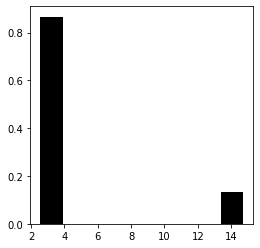

In [45]:
x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

fig, ax = plt.subplots(1, 1, figsize=(4,4))
rs = x_rs
bins = np.linspace(min(rs), max(rs), 10)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
ax.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, color='black')
print(np.argmin(rs), np.argmax(rs))

260.0030610789719


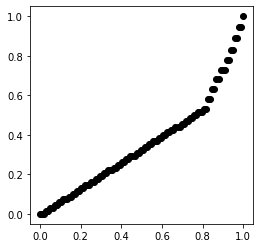

In [34]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
# for i in range(m*ell):
#     gen_qbts = qbts[np.where(Hz[i])[0]]
#     rs.append(make_circle(gen_qbts)[2])

# bins = np.linspace(min(rs), max(rs), 20)
# counts, _ = np.histogram(rs, bins=bins)
# counts_weighter = counts.sum()
# plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
rs = sorted(rs)
print(sum(rs))

fig, ax = plt.subplots(1, 1, figsize=(4,4))
work = [sum((rs)[:int(i*len(rs))])/sum(rs) for i in np.linspace(0,1,100)]
plt.scatter(np.linspace(0,1,100), work, c='k')

In [406]:
arr = []
for i, x in enumerate(x_rs):
    if (x > (min(x_rs))+np.std(x_rs)):
        arr.append(i)
print(arr)
print(len(arr)/Hx.shape[0])

[0, 1, 2, 21, 22, 23, 33, 34, 35]
0.2


In [3]:
codes = pd.read_csv("./codes/30_6/codes.csv")

# codes['min'] = mins
codes = codes.sort_values(by=['d','min','p_log'], ascending=[False,True,False])
# codes = codes.sort_values(by=['p_log'], ascending=[False])

# codes[:20]
codes.to_csv("./codes/30_6/sorted_codes.csv", index=None)

In [ ]:
[[(5, 16)], (0, 16)], 
[[(5, 18)], (0, 18)], 
[[(5, 4)], (0, 4)], 
[[(5, 20)], (0, 20)], 
[[(5, 6)], (0, 6)], 
[[(5, 22)], (0, 22)], 
[[(5, 8),], (0, 8)], 
[[(5, 24)], (0, 24)], 
[[(5, 10)], (0, 10)], 
[[(5, 26)], (0, 26)], 
[[(5, 12)], (0, 12)], 
[[(5, 28)], (0, 28)], 
[[(5, 14)], (0, 14)], 